<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков." data-toc-modified-id="Подготовка-признаков.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков.</a></span></li><li><span><a href="#Обучение-линейной-регрессии." data-toc-modified-id="Обучение-линейной-регрессии.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение линейной регрессии.</a></span></li><li><span><a href="#Обучение-случайного-леса." data-toc-modified-id="Обучение-случайного-леса.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение случайного леса.</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data_initial = data
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Выгрузили 26496 строк данных c 01.03.2018 по 31.08.2018, изменив тип столбца с датой с object на datetime64 и затем сделав даты индексами датасета.

Проверим, в хронологическом ли порядке расположены даты и время.

In [4]:
data.index.is_monotonic

True

Ресемплируем данные по одному часу, для агрегации взяв сумму заказов.

In [5]:
data = data.resample('1H').sum()

## Анализ

Построим график скользящего среднего с интервалом 100. По полученному графику можно отметить тренд - увеличение среднего количества заказов в течение полугода от марта до сентября. Возможно этот тренд является частью сезонности, которую мы не видим из-за недостаточного количесвтва данных.

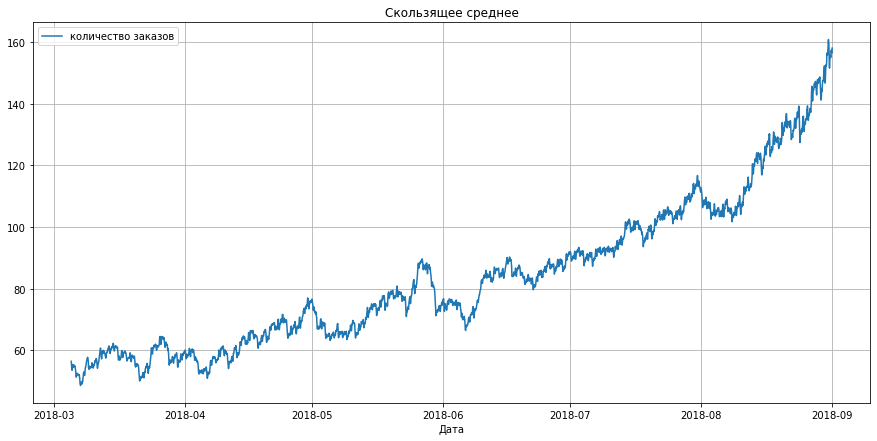

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(data.rolling(100).mean(), label='количество заказов')
plt.grid()
plt.title('Скользящее среднее')
plt.xlabel('Дата')
plt.legend()
plt.show()

Выведем график сезонности за первую неделю марта. По этому графику можно определить сезонность в данных: в течение суток количество заказов сильно снижается от полуночи до утра, а затем вновь начинает расти.

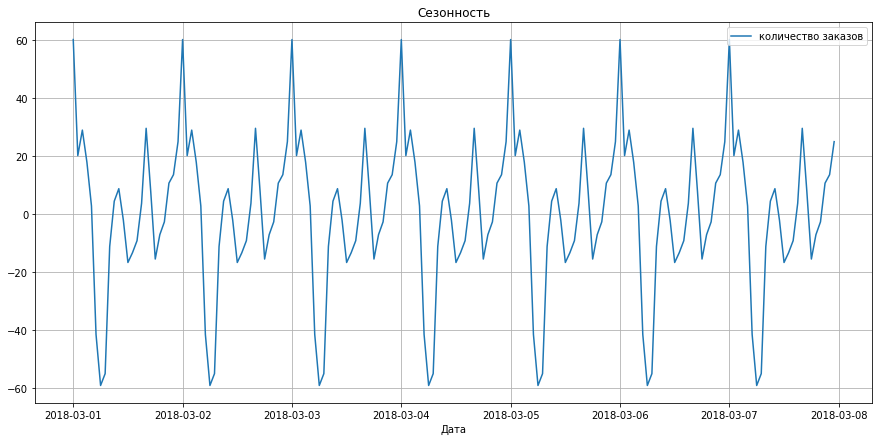

In [7]:
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(15, 7))
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-07'], label='количество заказов')
plt.grid()
plt.title('Сезонность')
plt.xlabel('Дата')
plt.legend()
plt.show()

Таким образом в исходных данных удалось обнаружить как наличие в них тренда, так и их сезонность.

## Обучение

### Подготовка признаков.

Создадим признаки для горизонта прогнозирования. Среди них возьмем день недели, предыдущие значения временного ряда и скользяще среднее.

In [8]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 2, 24)
data.head(5)

,num_orders,hour,dayofweek,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN


Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

In [9]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

def check_size(name, sample):
    print(f'Размер {name} выборки датасета: {len(sample)}')
    print(f'Минимальное и максимально значения {name} выборки: {sample.index.min(), sample.index.max()}')
check_size('обучающей', train)
check_size('тестовой', test)

Размер обучающей выборки датасета: 3950
Минимальное и максимально значения обучающей выборки: (Timestamp('2018-03-02 00:00:00'), Timestamp('2018-08-13 13:00:00'))
Размер тестовой выборки датасета: 442
Минимальное и максимально значения тестовой выборки: (Timestamp('2018-08-13 14:00:00'), Timestamp('2018-08-31 23:00:00'))


Выделим из обучающей и тестовой выборок целевой признак.

In [10]:
X_train, y_train = train.drop(columns='num_orders'), train['num_orders']
X_test, y_test = test.drop(columns='num_orders'), test['num_orders']

### Обучение линейной регрессии.

Построим модель линейной регрессии и проверим её на кросс-валидации.

In [11]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

MSE_lin_reg = np.mean(cross_validate(model_lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')['test_score'])

print(f'Значение RMSE линейной регрессии при проверке на кросс-валидации: {np.abs(MSE_lin_reg)**0.5}')

Значение RMSE линейной регрессии при проверке на кросс-валидации: 31.040357013168386


### Обучение случайного леса.

Построим модель случайного леса с подбором параметров через GridSearch.

In [12]:
GS_params = {'max_depth': range(1, 15),
             'n_estimators': range(1, 51, 10)}

split_index = TimeSeriesSplit().split(X_train)

GS_random_forest = GridSearchCV(RandomForestRegressor(random_state=1),
                                param_grid=GS_params,
                                scoring='neg_mean_squared_error',
                                cv=split_index)
GS_random_forest.fit(X_train, y_train)

MSE_random_forest = GS_random_forest.best_score_

print(f'Лучшее RMSE случайного леса: {np.abs(MSE_random_forest)**0.5}')
print(f'Параметры модели случайного леса: {GS_random_forest.best_params_}')

C:\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


Лучшее RMSE случайного леса: 28.066632851023726
Параметры модели случайного леса: {'max_depth': 14, 'n_estimators': 41}


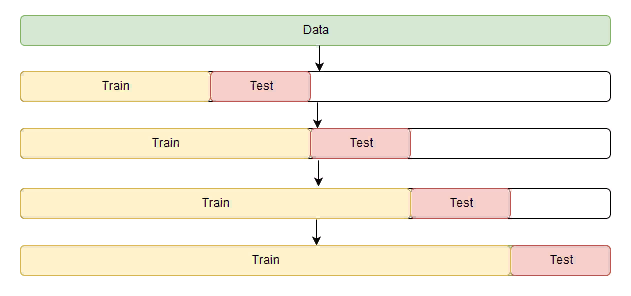

Построим модель градиентного бустинга из библиотеки LightGBM, ее впоследствии проверим на тестовой выборке.

In [13]:
train_data_lgb = lgb.Dataset(X_train, y_train)

parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'learning_rate': 0.05,
    'verbose': -1}

model_lgb = lgb.train(parameters, train_data_lgb, 5000, verbose_eval=False)

## Тестирование

Проверим все три модели на тестовой выборке.

In [14]:
prediction_lin_reg = model_lin_reg.predict(X_test)
print(f'RMSE линейной регрессии при проверке на тестовой выборке {mean_squared_error(y_test, prediction_lin_reg)**0.5}')

prediction_rand_for = GS_random_forest.predict(X_test)
print(f'RMSE случайного леса при проверке на тестовой выборке {mean_squared_error(y_test, prediction_rand_for)**0.5}')

prediction_lgm = model_lgb.predict(X_test)
print(f'RMSE градиентного бустинга при проверке на тестовой выборке {mean_squared_error(y_test, prediction_lgm)**0.5}')

RMSE линейной регрессии при проверке на тестовой выборке 51.26866698864004
RMSE случайного леса при проверке на тестовой выборке 45.68721494924103
RMSE градиентного бустинга при проверке на тестовой выборке 47.28127593549997


In [15]:
results = {'Model':
           ['Линейная регрессия', 'Случайный лес', 'Градиентный бустинг LightGBM'],
           'RMSE':
           [mean_squared_error(y_test, prediction_lin_reg)**0.5, 
           mean_squared_error(y_test, prediction_rand_for)**0.5,
           mean_squared_error(y_test, prediction_lgm)**0.5]}
pd.DataFrame(results)

,Model,RMSE
0,Линейная регрессия,51.268667
1,Случайный лес,45.687215
2,Градиентный бустинг LightGBM,47.281276


### Выводы

В ходе проекта были обучены три модели для предсказания количество заказов такси на следующий час по данным обладающим признаками тренда и сезонности. Наилучшее значение метрики RMSE (45.68) показала модель случайного леса, но несмотря на это, требуемого значения меньше 48 при определенных параметрах признаков для горизонта прогнозирования (в нашем случае: количество отстающих значений - 2 и размер окна скользящего среднего - 24) достигла также модель градиентного бустинга LightGBM.

Выведем график сравнения предсказаний и фактических значений целевого признака за несколько дней в августе.

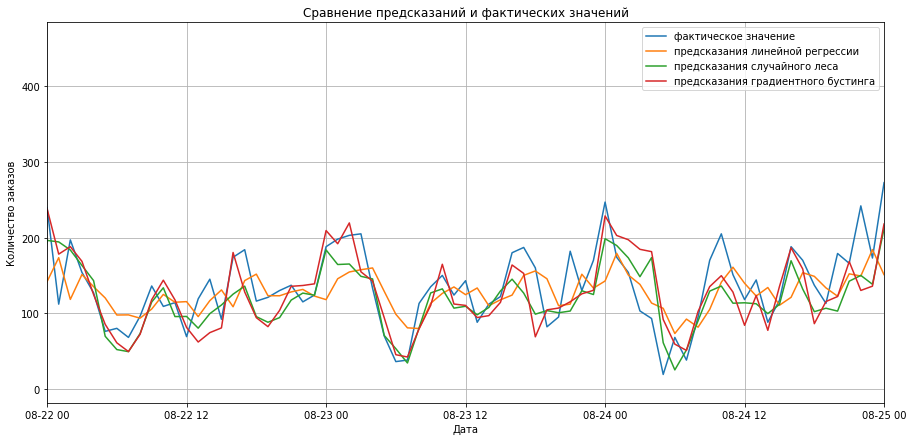

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='фактическое значение')
plt.plot(pd.Series(prediction_lin_reg, index=[y_test.index]), label='предсказания линейной регрессии')
plt.plot(pd.Series(prediction_rand_for, index=[y_test.index]), label='предсказания случайного леса')
plt.plot(pd.Series(prediction_lgm, index=[y_test.index]), label='предсказания градиентного бустинга')
plt.xlim(pd.Timestamp('2018-08-22'), pd.Timestamp('2018-08-25'))
plt.grid()
plt.title('Сравнение предсказаний и фактических значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()